In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_absolute_error,
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)

# Check keras version
print(tf.__version__)
print(keras.__version__)

2.20.0
3.12.0


In [2]:
# ==========================================
# 1. DATA PREPARATION & NORMALIZATION
# ==========================================
# Load the dataset
try:
    with np.load("dataset_dev_3000.npz") as data:
        X_raw = data["X"]
        y_raw = data["y"]
    print(f"Dataset loaded successfully: X={X_raw.shape}, y={y_raw.shape}")
except FileNotFoundError:
    # Fallback for demonstration
    print("WARNING: 'dataset_dev_3000.npz' not found. Generating dummy data.")
    X_raw = np.random.uniform(0, 7, (3000, 32, 32)).astype("float32")
    y_raw = np.column_stack(
        [
            np.random.randint(0, 10, 3000),  # Target A
            np.random.randint(0, 32, 3000),  # Target B
            np.random.rand(3000),  # Target C
        ]
    ).astype("float32")

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

print("--- 1. DATA PREPARATION ---")

# Calculate Global Max from Training Data
GLOBAL_MAX = float(X_train.max())
print(f"Global Max found in training data: {GLOBAL_MAX:.4f}")

# --- CRITICAL FIX: RESHAPE & NORMALIZE ---
# We must add the channel dimension: (N, 32, 32) -> (N, 32, 32, 1)
# AND normalize to [0, 1]
X_train_norm = X_train.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX
X_val_norm = X_val.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX
X_test_norm = X_test.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX

# Verify stats
print(f"Train Norm Shape: {X_train_norm.shape} (Must be Rank-4)")
print(f"Train Norm Range: [{X_train_norm.min():.3f}, {X_train_norm.max():.3f}]")

# Split Targets
y_train_A = y_train[:, 0]
y_train_B = y_train[:, 1]
y_train_C = y_train[:, 2]

y_val_A = y_val[:, 0]
y_val_B = y_val[:, 1]
y_val_C = y_val[:, 2]

y_test_A = y_test[:, 0]
y_test_B = y_test[:, 1]
y_test_C = y_test[:, 2]

Dataset loaded successfully: X=(3000, 32, 32), y=(3000, 3)
--- 1. DATA PREPARATION ---
Global Max found in training data: 6.8083
Train Norm Shape: (1920, 32, 32, 1) (Must be Rank-4)
Train Norm Range: [0.000, 1.000]


In [3]:
# ==========================================
# 2. MODEL ARCHITECTURE
# ==========================================
# Clear TF/Keras global state so re-running this cell rebuilds a *fresh* model.
# (This does NOT reset an already-created model; it prevents graph/state buildup.)
keras.backend.clear_session()

print("\n--- 2. BUILDING MODEL ---")


def build_model():
    inputs = keras.Input(shape=(32, 32, 1), name="img_input")

    # --- A. Data Augmentation ---
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(0.1)(x)

    # --- B. The Trunk ---
    # Block 1
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    # Block 2
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    # Block 3
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)

    features = layers.Dense(128, activation="relu")(x)

    # --- C. The Specialized Heads ---
    # Head A (0-9)
    branch_a = layers.Dense(64, activation="relu")(features)
    out_a = layers.Dense(10, activation="softmax", name="out_a")(branch_a)

    # Head B (0-31)
    branch_b = layers.Dense(64, activation="relu")(features)
    out_b = layers.Dense(32, activation="softmax", name="out_b")(branch_b)

    # Head C (Regression)
    branch_c = layers.Dense(32, activation="relu")(features)
    out_c = layers.Dense(1, activation="sigmoid", name="out_c")(branch_c)

    model = keras.Model(inputs=inputs, outputs=[out_a, out_b, out_c])
    return model


model = build_model()
# model.summary()



--- 2. BUILDING MODEL ---


In [4]:
# ==========================================
# 3. COMPILATION
# ==========================================
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "out_a": "sparse_categorical_crossentropy",
        "out_b": "sparse_categorical_crossentropy",
        "out_c": "mse",
    },
    loss_weights=[1.0, 1.0, 5.0],
    metrics={"out_a": "accuracy", "out_b": "accuracy", "out_c": "mae"},
)

In [5]:
# ==========================================
# 4. TRAINING
# ==========================================
print("\n--- 3. STARTING TRAINING ---")

callbacks = [
    # If LR is small, progress per epoch can be slow/noisy; let it run longer and
    # optionally auto-reduce LR on plateaus before we give up.
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-4,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True,
        verbose=1,
    ),
]

history = model.fit(
    X_train_norm,
    [y_train_A, y_train_B, y_train_C],
    epochs=50,
    batch_size=32,
    validation_data=(X_val_norm, [y_val_A, y_val_B, y_val_C]),
    callbacks=callbacks,
    verbose=1,
)


--- 3. STARTING TRAINING ---
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.1554 - out_a_accuracy: 0.1099 - out_a_loss: 2.3007 - out_b_accuracy: 0.0203 - out_b_loss: 3.4702 - out_c_loss: 0.0769 - out_c_mae: 0.2363 - val_loss: 6.1215 - val_out_a_accuracy: 0.1562 - val_out_a_loss: 2.2834 - val_out_b_accuracy: 0.0229 - val_out_b_loss: 3.4689 - val_out_c_loss: 0.0738 - val_out_c_mae: 0.2216 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0561 - out_a_accuracy: 0.1250 - out_a_loss: 2.2628 - out_b_accuracy: 0.0271 - out_b_loss: 3.4652 - out_c_loss: 0.0656 - out_c_mae: 0.2115 - val_loss: 6.0588 - val_out_a_accuracy: 0.1521 - val_out_a_loss: 2.2556 - val_out_b_accuracy: 0.0271 - val_out_b_loss: 3.4687 - val_out_c_loss: 0.0669 - val_out_c_mae: 0.2189 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0076 - out_a_accuracy: 0.1323 - out_a_loss: 2.2433 - out_b_accuracy: 0.0385 - out_b_loss: 3.4587 - out_c_loss: 

# Data Quality Diagnostics


## Subset Overfitting Test


In [6]:
N = 32

X_train_small = X_train_norm[:N]
X_val_small = X_val_norm[:N]
y_small = y_train[:N]  

y_train_A = y_small[:, 0]
y_train_B = y_small[:, 1]
y_train_C = y_small[:, 2]

y_val_A = y_small[:, 0]
y_val_B = y_small[:, 1]
y_val_C = y_small[:, 2]

In [ ]:
# ==========================================
# 3. COMPILATION
# ==========================================
model = build_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "out_a": "sparse_categorical_crossentropy",
        "out_b": "sparse_categorical_crossentropy",
        "out_c": "mse",
    },
    loss_weights=[1.0, 1.0, 5.0],
    metrics={"out_a": "accuracy", "out_b": "accuracy", "out_c": "mae"},
)

# ==========================================
# 4. TRAINING
# ==========================================
print("\n--- 3. STARTING TRAINING ---")

callbacks = [
    # If LR is small, progress per epoch can be slow/noisy; let it run longer and
    # optionally auto-reduce LR on plateaus before we give up.
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-4,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True,
        verbose=1,
    ),
]

history = model.fit(
    X_train_small,
    [y_train_A, y_train_B, y_train_C],
    epochs=50,
    validation_data=(X_val_small, [y_val_A, y_val_B, y_val_C]),
    callbacks=callbacks,
    verbose=1,
)


--- 3. STARTING TRAINING ---
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.1884 - out_a_accuracy: 0.1562 - out_a_loss: 2.3015 - out_b_accuracy: 0.0938 - out_b_loss: 3.4669 - out_c_loss: 0.0840 - out_c_mae: 0.2607 - val_loss: 6.1722 - val_out_a_accuracy: 0.1250 - val_out_a_loss: 2.3002 - val_out_b_accuracy: 0.1250 - val_out_b_loss: 3.4572 - val_out_c_loss: 0.0830 - val_out_c_mae: 0.2610 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 6.1737 - out_a_accuracy: 0.1562 - out_a_loss: 2.3011 - out_b_accuracy: 0.0938 - out_b_loss: 3.4575 - out_c_loss: 0.0830 - out_c_mae: 0.2604 - val_loss: 6.1561 - val_out_a_accuracy: 0.1250 - val_out_a_loss: 2.2965 - val_out_b_accuracy: 0.1250 - val_out_b_loss: 3.4486 - val_out_c_loss: 0.0822 - val_out_c_mae: 0.2609 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 6.1587 - out_a_accuracy: 0.1250 - out_a_loss: 2.2984 - out_b_accuracy: 0.1250 - out_b_loss: 3.4459 - out_c_loss: 0.0829 -

## Label Shuffling Test


In [20]:
y_train_A = y_train[:, 0]
y_train_B = y_train[:, 1]
y_train_C = y_train[:, 2]

y_val_A = y_val[:, 0]
y_val_B = y_val[:, 1]
y_val_C = y_val[:, 2]

In [21]:
n = y_train.shape[0]
# One shared permutation
perm = np.random.permutation(n)

# Shuffle labels consistently across outputs
y_train_A = y_train_A[perm]
y_train_B = y_train_B[perm]
y_train_C = y_train_C[perm]

n = y_val.shape[0]
# One shared permutation
perm = np.random.permutation(n)

y_val_A = y_val_A[perm]
y_val_B = y_val_B[perm]
y_val_C = y_val_C[perm]


In [ ]:
# ==========================================
# 3. COMPILATION
# ==========================================
model = build_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "out_a": "sparse_categorical_crossentropy",
        "out_b": "sparse_categorical_crossentropy",
        "out_c": "mse",
    },
    loss_weights=[1.0, 1.0, 5.0],
    metrics={"out_a": "accuracy", "out_b": "accuracy", "out_c": "mae"},
)

# ==========================================
# 4. TRAINING
# ==========================================
print("\n--- 3. STARTING TRAINING ---")

callbacks = [
    # If LR is small, progress per epoch can be slow/noisy; let it run longer and
    # optionally auto-reduce LR on plateaus before we give up.
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-4,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True,
        verbose=1,
    ),
]

history = model.fit(
    X_train_norm,
    [y_train_A, y_train_B, y_train_C],
    epochs=50,
    validation_data=(X_val_norm, [y_val_A, y_val_B, y_val_C]),
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.1743 - out_a_accuracy: 0.1068 - out_a_loss: 2.3021 - out_b_accuracy: 0.0411 - out_b_loss: 3.4637 - out_c_loss: 0.0817 - out_c_mae: 0.2453 - val_loss: 6.2016 - val_out_a_accuracy: 0.1125 - val_out_a_loss: 2.3022 - val_out_b_accuracy: 0.0250 - val_out_b_loss: 3.4685 - val_out_c_loss: 0.0862 - val_out_c_mae: 0.2552 - learning_rate: 1.0000e-04
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1736 - out_a_accuracy: 0.1010 - out_a_loss: 2.3020 - out_b_accuracy: 0.0417 - out_b_loss: 3.4630 - out_c_loss: 0.0817 - out_c_mae: 0.2452 - val_loss: 6.2029 - val_out_a_accuracy: 0.1125 - val_out_a_loss: 2.3021 - val_out_b_accuracy: 0.0250 - val_out_b_loss: 3.4699 - val_out_c_loss: 0.0862 - val_out_c_mae: 0.2552 - learning_rate: 1.0000e-04
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1726 - out_a_accuracy: 0.1036 - out_a_loss: 2.3018 - out_b_accuracy: 0.0417 - out_b_loss: 3.4623 - out_c_loss: 0.0817 - out_c_mae: 0.

# Cont.


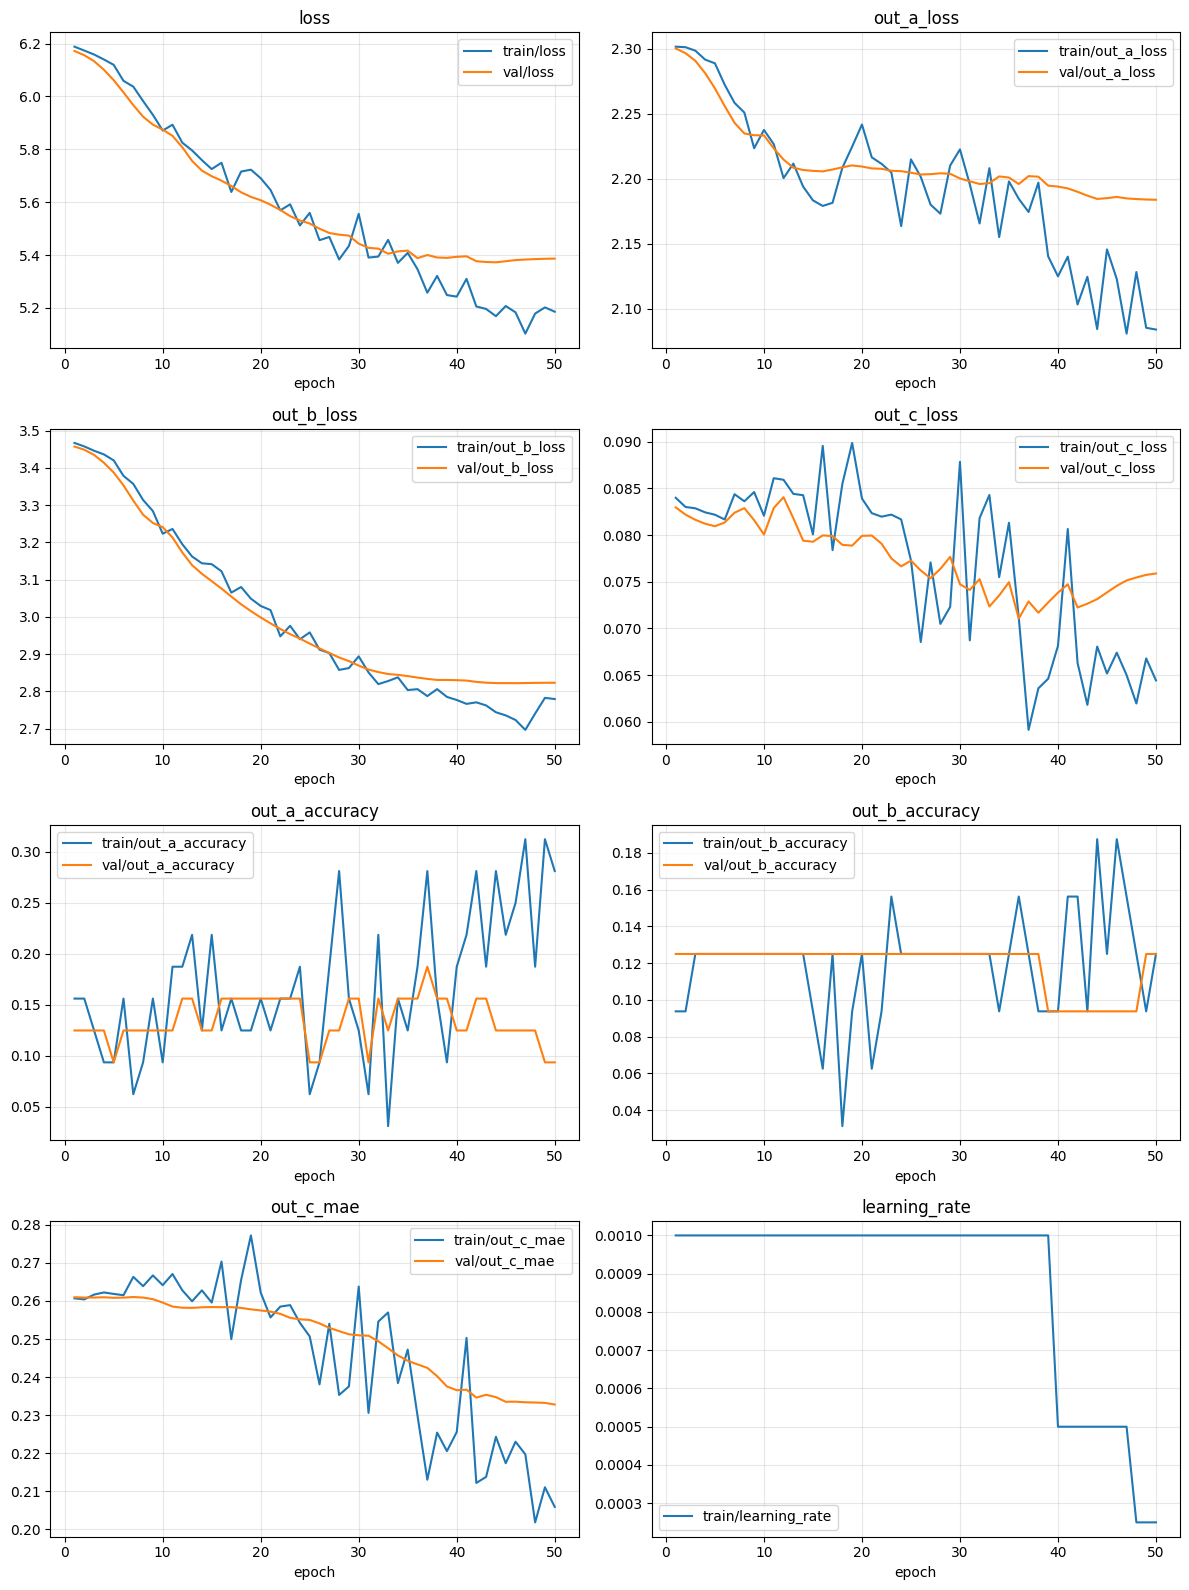

In [9]:
# Plot the history
hist = history.history

# Plot all tracked series (train vs val) in a grid.
base_keys = [k for k in hist.keys() if not k.startswith("val_")]

# Prefer a stable, readable ordering
preferred_order = [
    "loss",
    "out_a_loss",
    "out_b_loss",
    "out_c_loss",
    "out_a_accuracy",
    "out_b_accuracy",
    "out_c_mae",
]

ordered = [k for k in preferred_order if k in base_keys] + [
    k for k in base_keys if k not in preferred_order
]

n = len(ordered)
if n == 0:
    raise ValueError("history.history is empty; did model.fit() run?")

ncols = 2 if n > 1 else 1
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
axes = np.array(axes).reshape(-1)

epochs = np.arange(1, len(hist[ordered[0]]) + 1)

for i, key in enumerate(ordered):
    ax = axes[i]
    ax.plot(epochs, hist[key], label=f"train/{key}")

    vkey = f"val_{key}"
    if vkey in hist:
        ax.plot(epochs, hist[vkey], label=f"val/{key}")

    ax.set_title(key)
    ax.set_xlabel("epoch")
    ax.grid(True, alpha=0.3)
    ax.legend()

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [10]:
# ==========================================
# 5. PREDICT FUNCTION
# ==========================================
def predict_fn(X_raw):
    # 1. Reshape
    # 2. Normalize
    X_proc = X_raw.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX

    # 3. Predict
    pred_probs_a, pred_probs_b, pred_c_val = model.predict(X_proc, verbose=0)

    # 4. Process
    pred_a = np.argmax(pred_probs_a, axis=1)
    pred_b = np.argmax(pred_probs_b, axis=1)
    pred_c = pred_c_val.flatten()

    # 5. Stack
    return np.column_stack([pred_a, pred_b, pred_c])


print("\n--- CHECKING PREDICT_FN ---")
sample_preds = predict_fn(X_val[:5])
print("Output Shape:", sample_preds.shape)
print("Sample Predictions:\n", sample_preds)


--- CHECKING PREDICT_FN ---
Output Shape: (5, 3)
Sample Predictions:
 [[ 8.         20.          0.75362957]
 [ 6.         21.          0.32109755]
 [ 3.         20.          0.50017369]
 [ 3.         20.          0.58970344]
 [ 3.         20.          0.61744529]]



--- 4. EVALUATION & PLOTS ---
Generating predictions for Test Set...

TARGET A (Digits 0-9) PERFORMANCE
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        53
         1.0       0.00      0.00      0.00        66
         2.0       0.00      0.00      0.00        50
         3.0       0.10      0.58      0.17        55
         4.0       0.00      0.00      0.00        67
         5.0       0.00      0.00      0.00        56
         6.0       0.18      0.23      0.20        60
         7.0       0.00      0.00      0.00        74
         8.0       0.15      0.56      0.24        54
         9.0       0.00      0.00      0.00        65

    accuracy                           0.13       600
   macro avg       0.04      0.14      0.06       600
weighted avg       0.04      0.13      0.06       600



c:\Users\Admin\Desktop\DL\DL-ASM2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\Desktop\DL\DL-ASM2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\Desktop\DL\DL-ASM2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

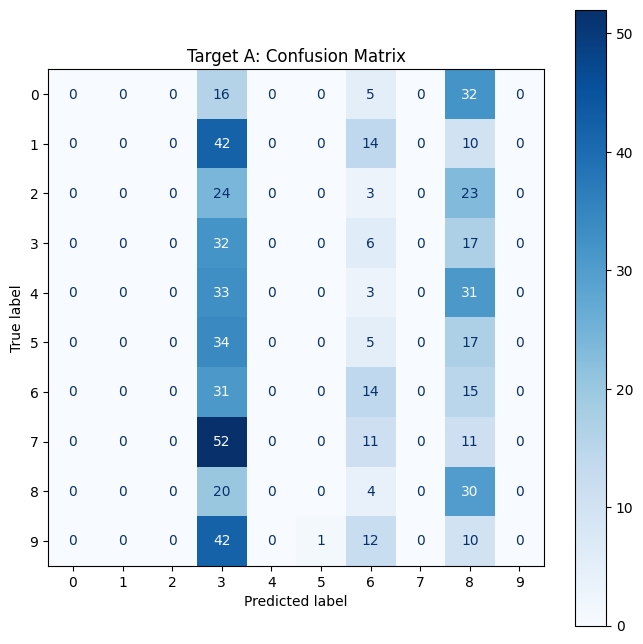


TARGET B (Classes 0-31) PERFORMANCE
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        23
         1.0       0.00      0.00      0.00        28
         2.0       0.00      0.00      0.00        13
         3.0       0.00      0.00      0.00        22
         4.0       0.00      0.00      0.00        17
         5.0       0.00      0.00      0.00        18
         6.0       0.00      0.00      0.00        12
         7.0       0.00      0.00      0.00        22
         8.0       0.00      0.00      0.00        18
         9.0       0.00      0.00      0.00        15
        10.0       0.00      0.00      0.00        15
        11.0       0.00      0.00      0.00        11
        12.0       0.00      0.00      0.00        27
        13.0       0.00      0.00      0.00        10
        14.0       0.00      0.00      0.00        14
        15.0       0.00      0.00      0.00        22
        16.0       0.00      0.00      0.00 

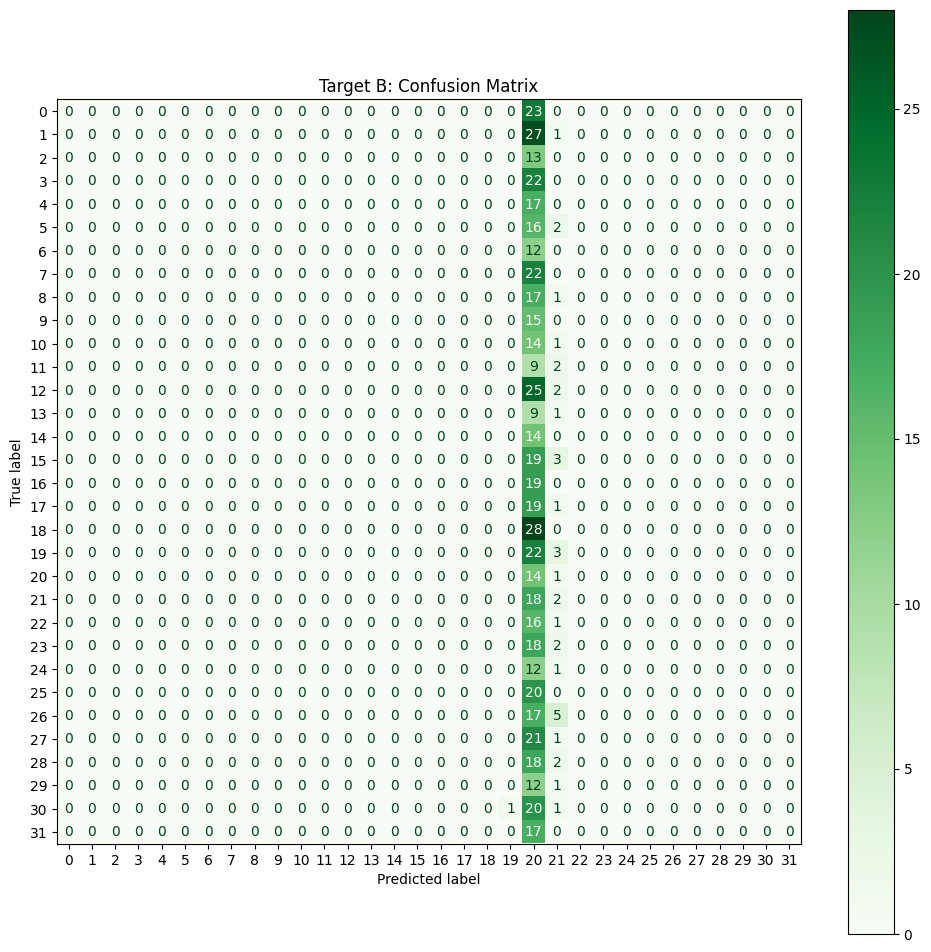


TARGET C (Regression) PERFORMANCE
Mean Absolute Error (MAE): 0.2203


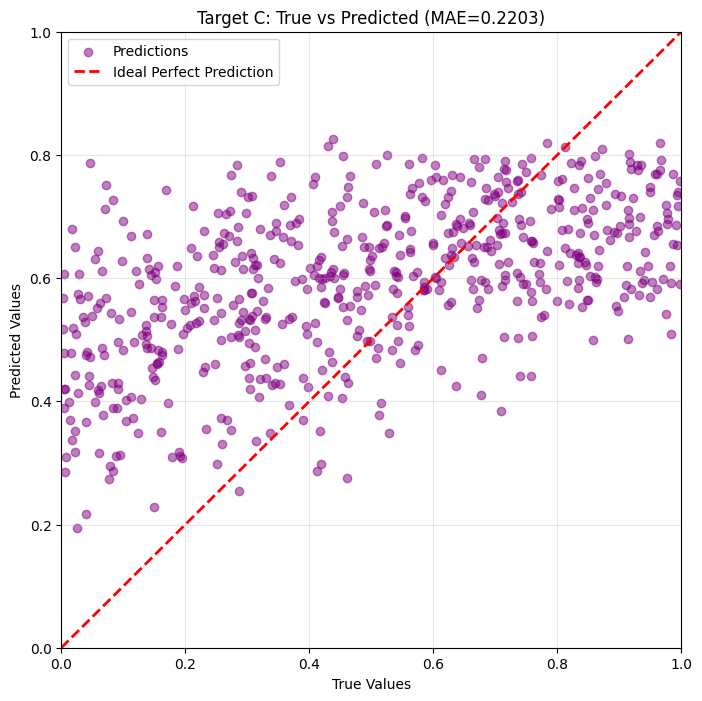

In [11]:
# ==========================================
# 6. EVALUATION & VISUALIZATION
# ==========================================
print("\n--- 4. EVALUATION & PLOTS ---")

# 1. Generate Predictions on Test Set
# We use the predict_fn wrapper which handles shaping/normalization automatically
print("Generating predictions for Test Set...")
val_preds = predict_fn(X_test)

# Extract components from the stacked predictions
# pred_a/b are class indices (integers), pred_c is float
pred_a = val_preds[:, 0].astype(int)
pred_b = val_preds[:, 1].astype(int)
pred_c = val_preds[:, 2]

# --- Target A (Classification 0-9) ---
print("\n" + "=" * 40)
print("TARGET A (Digits 0-9) PERFORMANCE")
print("=" * 40)
print(classification_report(y_test_A, pred_a))

# Plot Confusion Matrix for A
fig_a, ax_a = plt.subplots(figsize=(8, 8))
cm_a = confusion_matrix(y_test_A, pred_a)
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=np.arange(10))
disp_a.plot(cmap=plt.cm.Blues, ax=ax_a)
ax_a.set_title("Target A: Confusion Matrix")
plt.show()

# --- Target B (Classification 0-31) ---
print("\n" + "=" * 40)
print("TARGET B (Classes 0-31) PERFORMANCE")
print("=" * 40)
# Note: Zero_division=0 handles classes that might not appear in validation set
print(classification_report(y_test_B, pred_b, zero_division=0))

# Plot Confusion Matrix for B
fig_b, ax_b = plt.subplots(figsize=(12, 12))
cm_b = confusion_matrix(y_test_B, pred_b)
# We don't list all 32 labels on axis to keep it clean, or we can just use default ints
disp_b = ConfusionMatrixDisplay(confusion_matrix=cm_b)
disp_b.plot(cmap=plt.cm.Greens, ax=ax_b, values_format="d")  # 'd' for integers
ax_b.set_title("Target B: Confusion Matrix")
plt.show()

# --- Target C (Regression 0-1) ---
print("\n" + "=" * 40)
print("TARGET C (Regression) PERFORMANCE")
print("=" * 40)
mae_c = mean_absolute_error(y_test_C, pred_c)
print(f"Mean Absolute Error (MAE): {mae_c:.4f}")

# Plot True vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test_C, pred_c, alpha=0.5, color="purple", label="Predictions")
plt.plot([0, 1], [0, 1], "r--", linewidth=2, label="Ideal Perfect Prediction")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Target C: True vs Predicted (MAE={mae_c:.4f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()